# **Test notebook for the WongSolver in a single Glasma event**

## Glasma parameters

In [1]:
import numpy as np

# hbar * c [GeV * fm]
hbarc = 0.197326 

# Simulation box 
L = 10      
N = 512    
tau_sim = 1.0     
DTS = 8     

# Glasma
su_group = 'su2'
Qs = 2        
ns = 50    
factor = 0.8        
g2mu = Qs / factor     
g = np.pi * np.sqrt(1 / np.log(Qs / 0.2))          		
mu = g2mu / g**2          	
ir = 0.1 * g**2 * mu         
uv = 10.0        

## Wong solver parameters

In [2]:
mass = 1.27      
tau_form = 1/(2*mass)*hbarc       
pT = 0    
ntp = 10**5  
representation = 'fundamental'      
boundary = 'periodic'     

## Set environment variables & import relevant modules

In [3]:
import os
os.environ["MY_NUMBA_TARGET"] = "cuda"
os.environ["PRECISION"] = "double"
os.environ["GAUGE_GROUP"] = su_group

# Import relevant modules
import sys
sys.path.append('..')

# Glasma modules
import curraun.core as core
import curraun.mv as mv
import curraun.initial as initial
initial.DEBUG = False

import curraun.su as su
from curraun.numba_target import use_cuda
if use_cuda:
    from numba import cuda

# Wong modules
from curraun import wong
wong.BOUNDARY = boundary
wong.WONG_TO_HOST = True
wong.NUM_CHECK = True
wong.CASIMIRS = True
from curraun.wong import init_mom, init_pos, init_charge

Using CUDA
Using SU(2)
Using double precision
Using double precision
Using double precision


ImportError: cannot import name 'init_mom'

## Initialize the Glasma fields

In [4]:
# Derived parameters
a = L / N
E0 = N / L * hbarc
DT = 1.0 / DTS
formt = int(tau_form / a * DTS)
maxt = int(tau_sim / a * DTS)

# Initialize Glasma fields
s = core.Simulation(N, DT, g)
va = mv.wilson(s, mu=mu / E0, m=ir / E0, uv=uv / E0, num_sheets=ns)
vb = mv.wilson(s, mu=mu / E0, m=ir / E0, uv=uv / E0, num_sheets=ns)
initial.init(s, va, vb)

## Initialize the Wong solver

In [5]:
# Initialize the Wong solver
wong_solver = wong.WongSolver(s, ntp)
x0s, p0s, q0s = np.zeros((ntp, 3)), np.zeros((ntp, 5)), np.zeros((ntp, su.ALGEBRA_ELEMENTS))
masses = mass / E0 * np.ones(ntp)

for i in range(ntp):
    x0, p0, q0 = init_pos(s.n), init_mom('pT', pT / E0), init_charge(representation)
    x0s[i, :], p0s[i, :], q0s[i, :] = x0, p0, q0

wong_solver.initialize(x0s, p0s, q0s, masses)

## Evolve the Glasma fields & solve Wong's equations

In [6]:
from tqdm import tqdm

# Positions and momenta
xmu, pmu = np.zeros((maxt-formt, ntp, 3)), np.zeros((maxt-formt, ntp, 5))
p_sq_mean = np.zeros((maxt-formt, 3))
casimirs = np.zeros((maxt-formt, ntp, su.CASIMIRS))
ptau_constraint = np.zeros((maxt-formt, ntp))

with tqdm(total=maxt) as pbar:
    for t in range(maxt):
        # Evolve Glasma fields
        core.evolve_leapfrog(s)

        # Solve Wong's equations
        if t>=formt:  
            xmu[t-formt], pmu[t-formt] = wong_solver.x1.copy(), wong_solver.p.copy()
            p_sq_mean[t-formt] = wong_solver.p_sq_mean.copy()

            wong_solver.evolve()
            wong_solver.compute_mom_broad()

            wong_solver.compute_casimirs(representation)
            casimirs[t-formt] = wong_solver.c.copy()

            wong_solver.compute_ptau_constraint()
            ptau_constraint[t-formt] = wong_solver.ptau_constraint.copy()

        pbar.update(1)

100%|██████████| 409/409 [03:02<00:00,  2.24it/s]


## Import plotting packages

In [7]:
import matplotlib.pyplot as plt

plt.style.use('nord_theme.mpltstyle')

# Casimir invariants

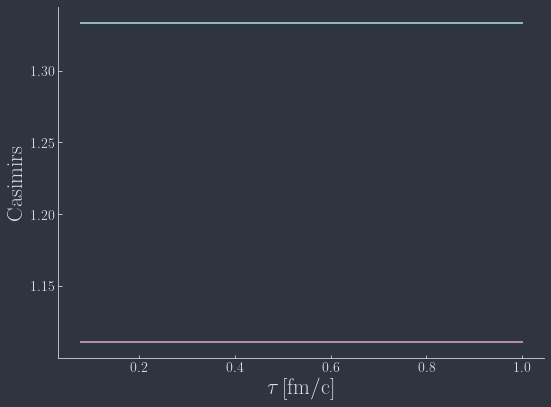

In [8]:
plt.rcParams["figure.figsize"] = (8, 6)

tau = np.linspace(tau_form, tau_sim, maxt-formt)
colors = ['#8FBCBB', '#B48EAD']
for i in range(500):
    for ci in range(su.CASIMIRS):
        plt.plot(tau, casimirs[:, i, ci], color=colors[ci])

plt.ylabel(r'$\mathrm{Casimirs}$')
plt.xlabel(r'$\tau\,\mathrm{[fm/c]}$')
plt.tight_layout()

# range for SU(2)
if su_group=='su2':
    plt.ylim([0.6, 0.9])

# $p^\tau$ constraint

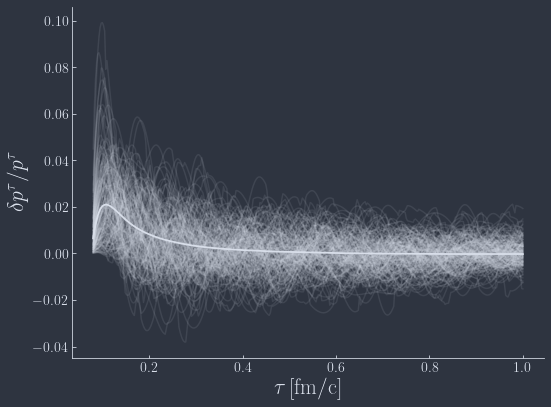

In [9]:
plt.rcParams["figure.figsize"] = (8, 6)

tau = np.linspace(tau_form, tau_sim, maxt-formt)
for i in range(200):
    rel_ptau_constraint = (ptau_constraint[:, i] - pmu[:, i, 0])/pmu[:, i, 0]
    plt.plot(tau, rel_ptau_constraint, color='#D8DEE9', alpha=0.1)

rel_ptau_constraint_all_part = (ptau_constraint - pmu[:, :, 0])/pmu[:, :, 0]
mean_rel_ptau_constraint = np.mean(rel_ptau_constraint_all_part, axis=1)
plt.plot(tau, mean_rel_ptau_constraint, color='#D8DEE9', linewidth=1.8)

plt.ylabel(r'$\delta p^\tau/p^\tau$')
plt.xlabel(r'$\tau\,\mathrm{[fm/c]}$')
plt.tight_layout()
plt.savefig('ptau_constraint.png', dpi=300, transparent=False)

# Plot positions

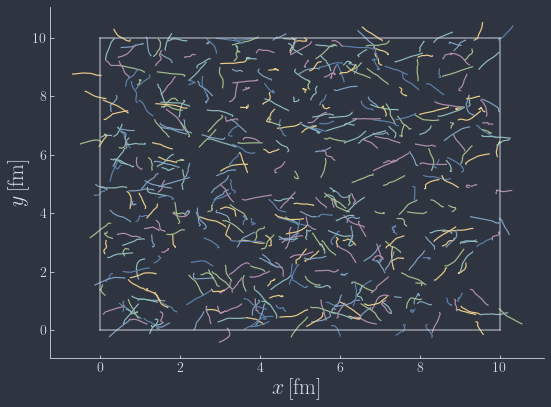

In [10]:
plt.rcParams["figure.figsize"] = (8, 6)

for i in range(500):
    plt.plot(xmu[:, i, 0] * a, xmu[:, i, 1] * a, linewidth=1.2)

border = np.linspace(0, L, N)
plt.plot(border, np.zeros(N), color='#D8DEE9', alpha=0.6, linewidth=1.5)
plt.plot(np.zeros(N), border, color='#D8DEE9', alpha=0.6, linewidth=1.5)
plt.plot(border, L*np.ones(N), color='#D8DEE9', alpha=0.6, linewidth=1.5)
plt.plot(L*np.ones(N), border, color='#D8DEE9', alpha=0.6, linewidth=1.5)

plt.ylabel(r'$y\,\mathrm{[fm]}$')
plt.xlabel(r'$x\,\mathrm{[fm]}$')
plt.tight_layout()

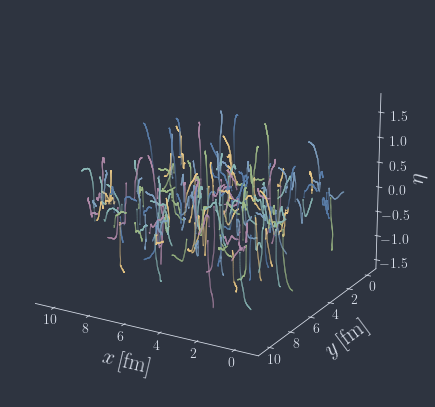

In [11]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = plt.axes(projection='3d')

for i in range(200):
    ax.scatter(xmu[:, i, 0] * a, xmu[:, i, 1] * a, xmu[:, i, 2], xmu[:, i, 2], s=0.02)

ax.set_xlabel(r'$x\,\mathrm{[fm]}$')
ax.set_ylabel(r'$y\,\mathrm{[fm]}$')
ax.set_zlabel(r'$\eta$')

ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.xaxis.pane.set_edgecolor('#2E3440')
ax.yaxis.pane.set_edgecolor('#2E3440')
ax.zaxis.pane.set_edgecolor('#2E3440')

ax.tick_params(axis='x', which='major', pad=-3)
ax.tick_params(axis='y', which='major', pad=-3)

ax.view_init(20, 120)
plt.tight_layout()

# Plot momenta

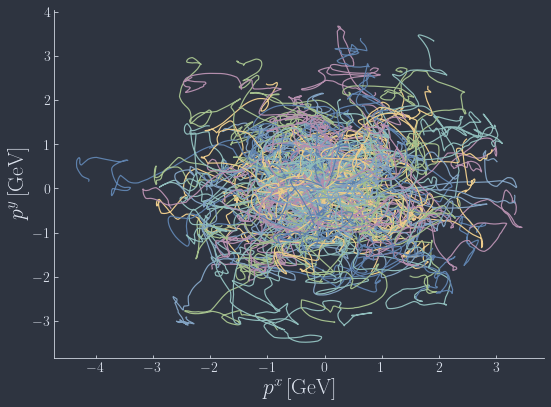

In [12]:
plt.rcParams["figure.figsize"] = (8, 6)
fig, ax = plt.subplots(1, 1)

for i in range(200):
    plt.plot(pmu[:, i, 1] * E0, pmu[:, i, 2] * E0, linewidth=1.2)

plt.ylabel(r'$p^y\,\mathrm{[GeV]}$')
plt.xlabel(r'$p^x\,\mathrm{[GeV]}$')

plt.tight_layout()

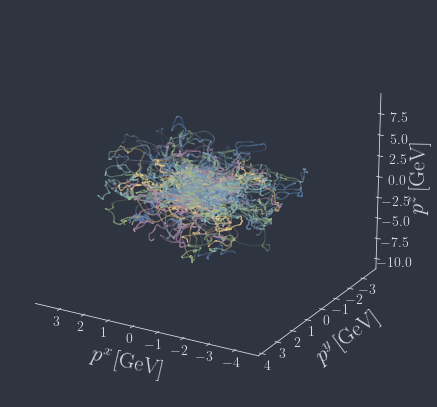

In [13]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = plt.axes(projection='3d')

for i in range(200):
    ax.scatter(pmu[:, i, 1] * E0, pmu[:, i, 2] * E0, pmu[:, i, 4] * E0, pmu[:, i, 4] * E0, s=0.02)

ax.set_xlabel(r'$p^x\,\mathrm{[GeV]}$')
ax.set_ylabel(r'$p^y\,\mathrm{[GeV]}$')
ax.set_zlabel(r'$p^z\,\mathrm{[GeV]}$')

ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.xaxis.pane.set_edgecolor('#2E3440')
ax.yaxis.pane.set_edgecolor('#2E3440')
ax.zaxis.pane.set_edgecolor('#2E3440')

ax.tick_params(axis='x', which='major', pad=-3)
ax.tick_params(axis='y', which='major', pad=-3)
# ax.yaxis.set_major_locator(plt.MaxNLocator(5))
# ax.xaxis.set_major_locator(plt.MaxNLocator(5))

ax.view_init(20, 120)
plt.tight_layout()

## Plot momentum broadenings

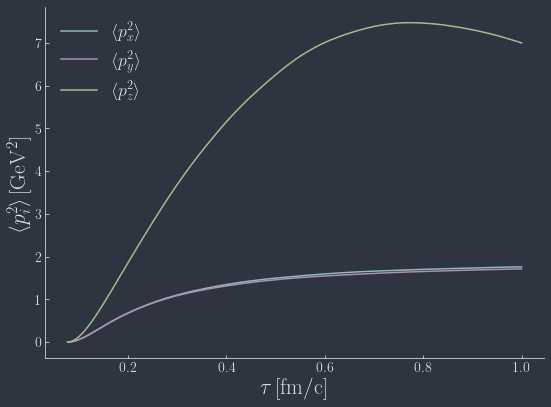

In [14]:
plt.rcParams["figure.figsize"] = (8, 6)
# fig, ax = plt.subplots(1, 1)

tau = np.linspace(tau_form, tau_sim, maxt-formt)
plt.plot(tau, p_sq_mean[:, 0] * E0**2, label=r'$\langle p_x^2\rangle$')
plt.plot(tau, p_sq_mean[:, 1] * E0**2, label=r'$\langle p_y^2\rangle$')
plt.plot(tau, p_sq_mean[:, 2] * E0**2, label=r'$\langle p_z^2\rangle$')

plt.xlabel(r'$\tau\,\mathrm{[fm/c]}$')
plt.ylabel(r'$\langle p_i^2\rangle \,\mathrm{[GeV^2]}$')

plt.legend()
plt.tight_layout()